#### Merge Seurat3-integrated DR with original anndata object
#### and process further downstream
---
##### hpb29

Date: 2021-01-08

In [1]:
%matplotlib nbagg

import warnings
warnings.filterwarnings('ignore')

import os, sys, json, getpass
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
with open('/.singularity.d/labels.json') as fh:
    singularity = json.load(fh)
    
singularity['Version']

'mictlan.20f'

In [3]:
sc.settings.verbosity = 3
sc.settings.file_format_figs = 'svg'
sc.settings.savefigs = False
sc.set_figure_params(dpi=150)

In [4]:
home = str(Path.home())
user = getpass.getuser()

basedir = os.path.join(home, 'datafloor/users', user, '2020/SLX19841/')

sc.settings.writedir = os.path.join(basedir, 'analysis/h5ad/')

In [5]:
now = datetime.now()
prefix = now.strftime('%Y%m%d')
print(prefix)

20210108


In [6]:
basename = '_COMBO10_NO_SPL3_Seurat3_Integrated_'

In [7]:
headers= ['cluster', 'size', 
          'D1 BM', 'D1 PB', 'D1 SPL', 
          'D2 BM', 'D2 PB', 'D2 SPL', 
          'D3 BM', 'D4 BM', 'D4 SPL', 
          'TQ198', 'BP62j', 'BP37d', 
          'BP74', 'BP1c', 'BP59h']

In [9]:
def plot_groupings(data, grouping):

    fig,ax = plt.subplots(3,4,  squeeze=True, sharex=True, sharey=True, figsize=(16.5,12.5))
    fig.tight_layout()
    ax = ax.ravel()
    print(len(ax))
    i = 0

    for g in data.obs['donor'].unique():
        try:
            sc.pl.umap(data, ax=ax[i])
            sc.pl.umap(data[data.obs['donor'] == g, :], color=[grouping], 
                       ax=ax[i], title=g, legend_loc='on data')

            ax[i].collections[0].set_sizes([20])
            ax[i].collections[1].set_sizes([20])

            ax[i].get_xaxis().set_visible(False)
            ax[i].get_yaxis().set_visible(False)
            i += 1
        except IndexError:
            pass

    fig.text(0.5, 0.01, 'UMAP1', ha='center', va='center')
    fig.text(0.025, 0.5, 'UMAP2', ha='center', va='center', rotation=90)

In [10]:
%%time
integrated = sc.read('COMBO10_NO_SPL3_Seurat3_data_integrated')

CPU times: user 30.6 s, sys: 3.19 s, total: 33.8 s
Wall time: 33.7 s


... storing 'donor' as categorical
... storing 'organ' as categorical


<IPython.core.display.Javascript object>


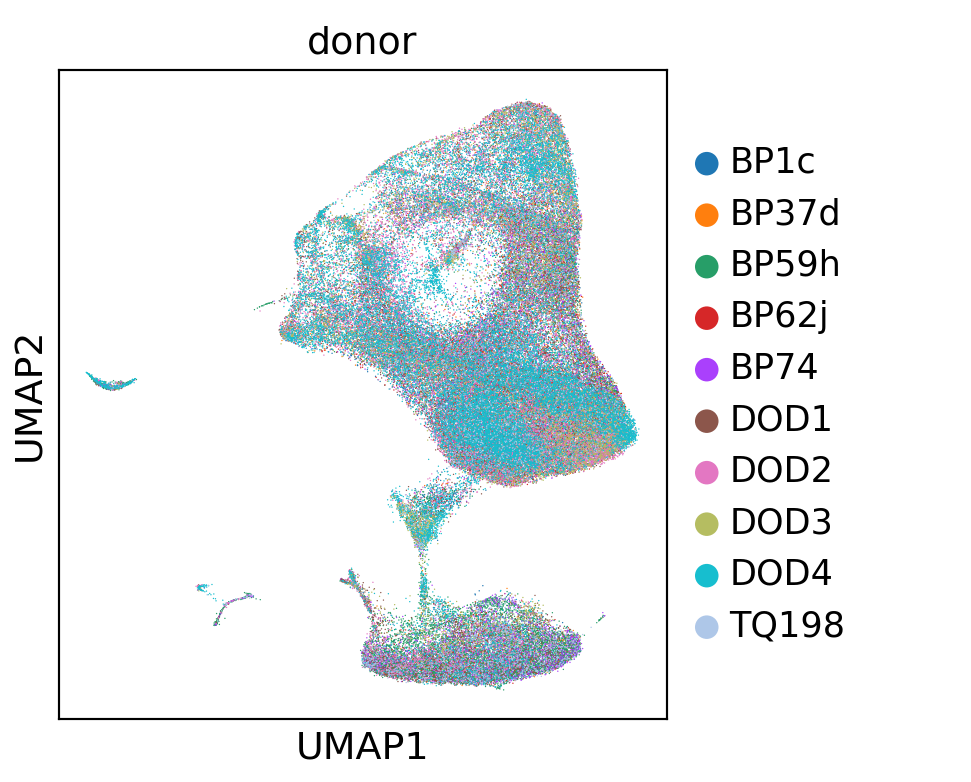

In [14]:
sc.pl.scatter(integrated, basis='umap', color='donor')

In [15]:
integrated.obs.donor.unique()

['DOD1', 'DOD2', 'DOD3', 'DOD4', 'TQ198', 'BP62j', 'BP37d', 'BP74', 'BP1c', 'BP59h']
Categories (10, object): ['DOD1', 'DOD2', 'DOD3', 'DOD4', ..., 'BP37d', 'BP74', 'BP1c', 'BP59h']

<IPython.core.display.Javascript object>


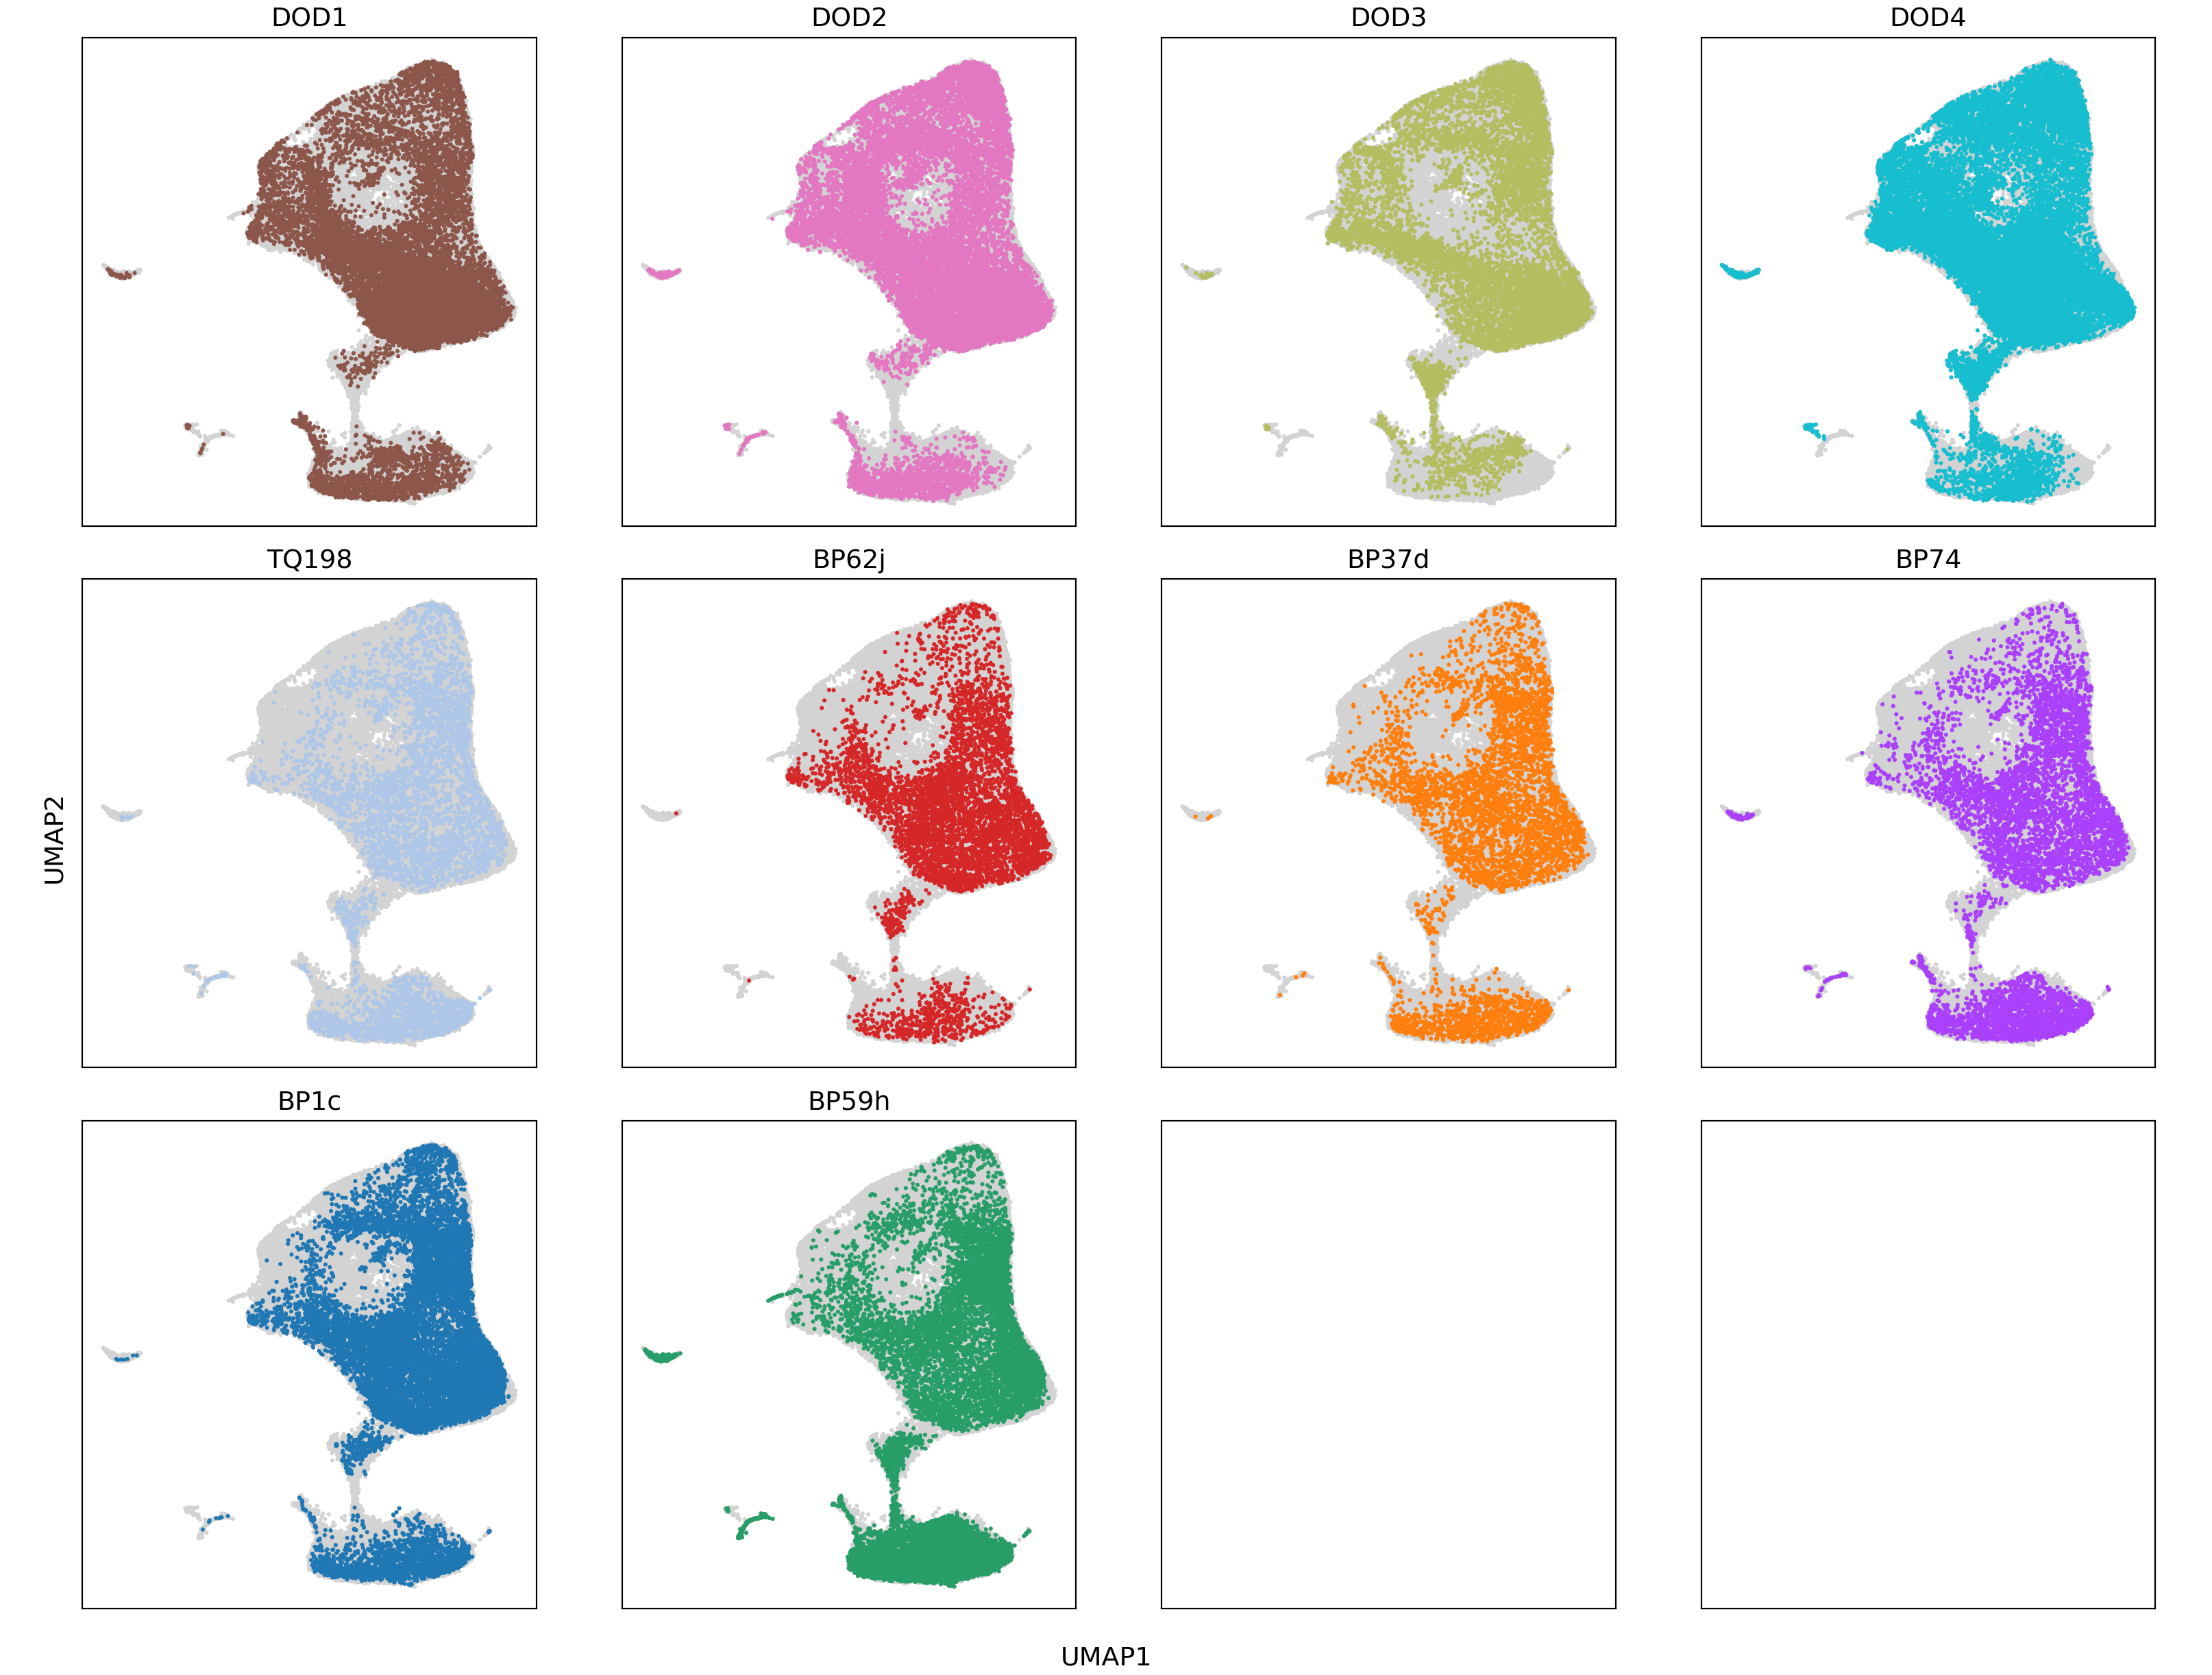

12


Text(0.025, 0.5, 'UMAP2')

In [16]:
fig,ax = plt.subplots(3,4,  squeeze=True, sharex=True, sharey=True, figsize=(16.5,12.5))
fig.tight_layout()
ax = ax.ravel()
print(len(ax))
i = 0

for g in integrated.obs['donor'].unique():
    try:
        sc.pl.umap(integrated, ax=ax[i])
        sc.pl.umap(integrated[integrated.obs['donor'] == g, :], color=['donor'], 
                                       ax=ax[i], title=g, legend_loc=None)
        ax[i].collections[0].set_sizes([20])
        ax[i].collections[1].set_sizes([20])
        #ax[i].set_xlim((-20,40))
        #ax[i].set_ylim((-20,40))
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        i += 1
    except IndexError:
        pass
    
fig.text(0.5, 0.01, 'UMAP1', ha='center', va='center')
fig.text(0.025, 0.5, 'UMAP2', ha='center', va='center', rotation=90)

---

---

In [23]:
integrated.raw.X

<118783x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 193024153 stored elements in Compressed Sparse Row format>

In [24]:
del integrated.raw

In [25]:
integrated

AnnData object with n_obs × n_vars = 118783 × 2000
    obs: 'nCount_RNA', 'nFeature_RNA', 'donor', 'organ', 'seurat_clusters'
    var: 'features'
    uns: 'neighbors', 'donor_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

##### Get all the original counts

(it has all cells but it doesnt matter because I am only going to use the intersection hence filtering them)

In [26]:
%%time
counts = sc.read('COMBO10_counts_doublet_filtered_BEFORE_per_cell_normalization')

CPU times: user 18 s, sys: 1.52 s, total: 19.5 s
Wall time: 19.4 s


In [27]:
counts

AnnData object with n_obs × n_vars = 122857 × 24344
    obs: 'batch', 'donor', 'library', 'organ', 'n_counts', 'n_counts_log', 'percent_mitoc', 'n_genes'
    var: 'gene_ids', 'n_cells'
    layers: 'counts'

In [28]:
common = integrated.obs.index.intersection(counts.obs.index)

Get just the counts for the cells that intersect with the integrated object

In [30]:
merged = counts[common].copy()

In [31]:
merged

AnnData object with n_obs × n_vars = 118783 × 24344
    obs: 'batch', 'donor', 'library', 'organ', 'n_counts', 'n_counts_log', 'percent_mitoc', 'n_genes'
    var: 'gene_ids', 'n_cells'
    layers: 'counts'

In [32]:
# transfer DR from integrated data
merged.uns['donor_colors'] = integrated[merged.obs.index].uns['donor_colors'].copy()

merged.obsm['X_pca'] = integrated[merged.obs.index].obsm['X_pca'].copy()
merged.obsm['X_umap'] = integrated[merged.obs.index].obsm['X_umap'].copy()

Filter out zero expression-genes

In [52]:
nonzero = merged.X.sum(axis=0) > 0

nonzero = nonzero.tolist()[0]

In [53]:
print( len(nonzero), sum(nonzero) )

24344 24332


Notice that I already had a ``counts`` layer from before

In [55]:
merged[: , nonzero]

View of AnnData object with n_obs × n_vars = 118783 × 24332
    obs: 'batch', 'donor', 'library', 'organ', 'n_counts', 'n_counts_log', 'percent_mitoc', 'n_genes'
    var: 'gene_ids', 'n_cells'
    uns: 'donor_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [56]:
merged = merged[: , nonzero].copy()

In [58]:
%%time
sc.pp.normalize_total(merged, target_sum=1e4, exclude_highly_expressed=True)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['JUN', 'S100A9', 'S100A8', 'IL8', 'PPBP', 'TMSB4X', 'HBB', 'FTH1', 'NEAT1', 'MALAT1', 'FOS', 'B2M', 'MT2A', '7SK-2', 'AVP', 'FTL', 'IGLL5', 'MT-CO1', 'MT-ATP6', 'MT-CO3']
    finished (0:00:02)
CPU times: user 7.01 s, sys: 4.1 s, total: 11.1 s
Wall time: 11.1 s


In [59]:
sc.pp.log1p(merged, base=2)

In [60]:
merged.layers["lognorm"] = merged.X.copy()

In [61]:
%%time
sc.pp.highly_variable_genes(merged, 
                            min_mean=0.001, max_mean=5, min_disp=0.05)

extracting highly variable genes
    finished (0:00:07)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
CPU times: user 6.98 s, sys: 430 ms, total: 7.41 s
Wall time: 7.4 s


<IPython.core.display.Javascript object>


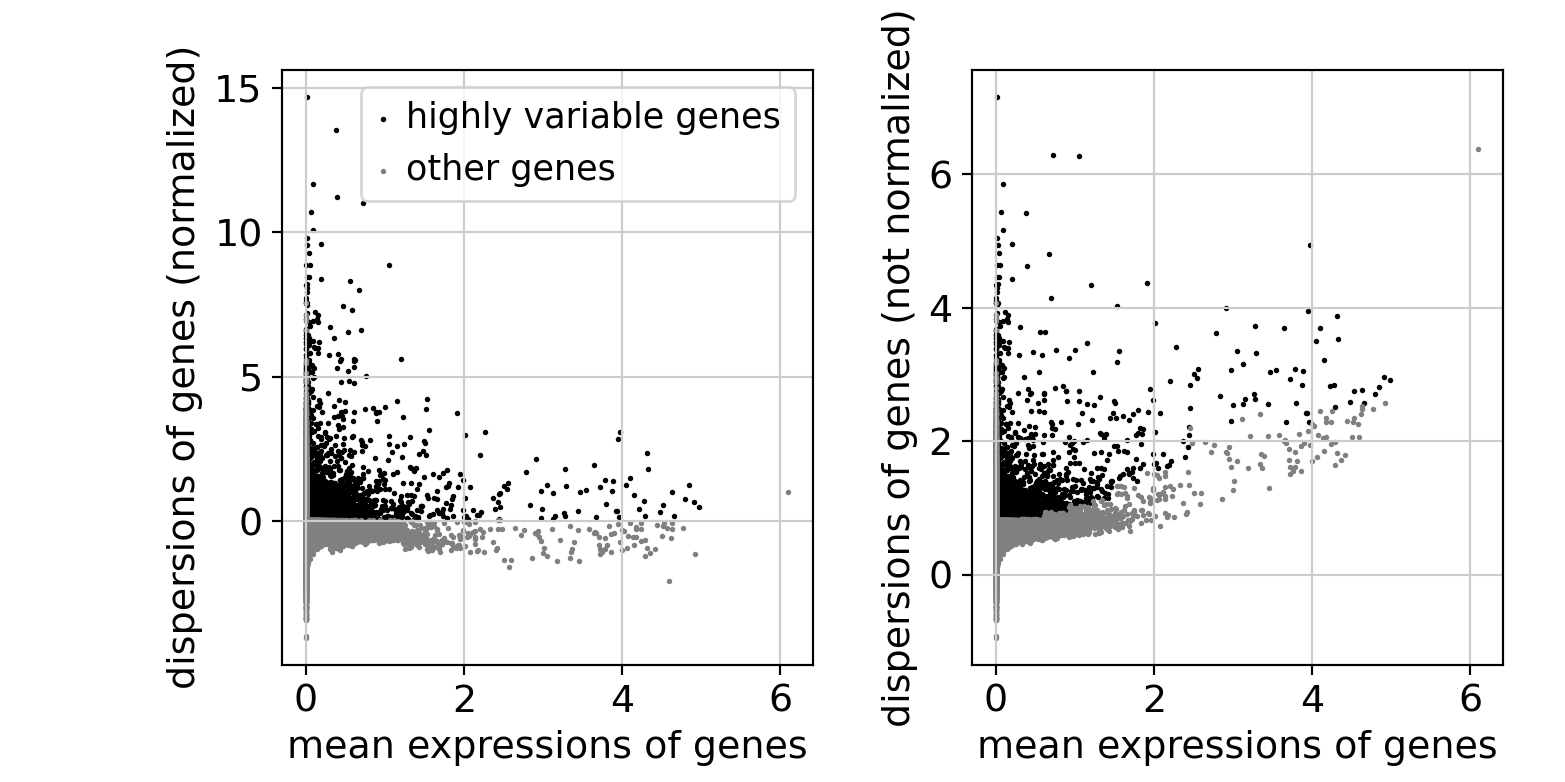

In [62]:
sc.pl.highly_variable_genes(merged)

In [63]:
sc.pp.neighbors(merged)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:44)


##### Merge and transfer annotations between objects

In [64]:
meta_mix = integrated.obs.merge(merged.obs, left_index=True, right_index=True)

In [67]:
meta_mix.batch.unique()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [68]:
meta = meta_mix[['batch', 'nCount_RNA', 'nFeature_RNA', 'library', 'donor_x', 'organ_x',
                 'seurat_clusters']]

meta.columns = ['batch', 'n_counts', 'n_genes', 'library', 'donor', 'organ',
                 'seurat_clusters']

##### Insert adjusted merged metadata

In [73]:
merged.obs = meta.copy()

compute a number of arbitrary leiden resolutions

In [76]:
sc.tl.leiden(merged, resolution=0.6, key_added='leiden.0.6')

running Leiden clustering
    finished: found 17 clusters and added
    'leiden.0.6', the cluster labels (adata.obs, categorical) (0:00:59)


In [77]:
sc.tl.leiden(merged, resolution=0.7, key_added='leiden.0.7')

running Leiden clustering
    finished: found 19 clusters and added
    'leiden.0.7', the cluster labels (adata.obs, categorical) (0:01:40)


In [78]:
sc.tl.leiden(merged, resolution=0.8, key_added='leiden.0.8')

running Leiden clustering
    finished: found 19 clusters and added
    'leiden.0.8', the cluster labels (adata.obs, categorical) (0:01:31)


In [79]:
sc.tl.leiden(merged, resolution=0.9, key_added='leiden.0.9')

running Leiden clustering
    finished: found 20 clusters and added
    'leiden.0.9', the cluster labels (adata.obs, categorical) (0:01:02)


In [80]:
sc.tl.leiden(merged, resolution=1.0, key_added='leiden.1.0')

running Leiden clustering
    finished: found 22 clusters and added
    'leiden.1.0', the cluster labels (adata.obs, categorical) (0:00:55)


In [81]:
sc.tl.leiden(merged, resolution=1.1, key_added='leiden.1.1')

running Leiden clustering
    finished: found 27 clusters and added
    'leiden.1.1', the cluster labels (adata.obs, categorical) (0:01:19)


In [82]:
sc.tl.leiden(merged, resolution=1.2, key_added='leiden.1.2')

running Leiden clustering
    finished: found 27 clusters and added
    'leiden.1.2', the cluster labels (adata.obs, categorical) (0:00:58)


In [83]:
sc.tl.leiden(merged, resolution=1.3, key_added='leiden.1.3')

running Leiden clustering
    finished: found 27 clusters and added
    'leiden.1.3', the cluster labels (adata.obs, categorical) (0:01:03)


---

In [84]:
sc.tl.draw_graph(merged, n_jobs=5)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:23:38)


---

In [91]:
sc.write('COMBO10_NO_SPL3_Seurat3_lognorm', merged)

---

In [103]:
def count_cells_per_group(data, grouping):

    counts = []

    for c in range(0, data.obs[grouping].nunique()):

        cluster_slice = data[ data.obs[grouping] == str(c), : ].copy()
        c_size = len(cluster_slice)

        d1_bm = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'DOD1',
                                   np.logical_and(cluster_slice.obs['organ'] == 'BM', 
                                                 cluster_slice.obs[grouping] == str(c)) ), : ])

        d1_pb = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'DOD1',
                                   np.logical_and(cluster_slice.obs['organ'] == 'PB', 
                                                 cluster_slice.obs[grouping] == str(c)) ), : ])

        d1_spl = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'DOD1',
                                    np.logical_and(cluster_slice.obs['organ'] == 'SPL', 
                                                  cluster_slice.obs[grouping] == str(c)) ), : ])


        d2_bm = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'DOD2',
                                   np.logical_and(cluster_slice.obs['organ'] == 'BM', 
                                                 cluster_slice.obs[grouping] == str(c)) ), : ])

        d2_pb = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'DOD2',
                                   np.logical_and(cluster_slice.obs['organ'] == 'PB', 
                                                 cluster_slice.obs[grouping] == str(c)) ), : ])

        d2_spl = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'DOD2',
                                    np.logical_and(cluster_slice.obs['organ'] == 'SPL', 
                                                  cluster_slice.obs[grouping] == str(c)) ), : ])    



        d3_bm = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'DOD3',
                                   np.logical_and(cluster_slice.obs['organ'] == 'BM', 
                                                 cluster_slice.obs[grouping] == str(c)) ), : ])



        d4_bm = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'DOD4',
                                   np.logical_and(cluster_slice.obs['organ'] == 'BM', 
                                                 cluster_slice.obs[grouping] == str(c)) ), : ])

        d4_spl = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'DOD4',
                                    np.logical_and(cluster_slice.obs['organ'] == 'SPL', 
                                                  cluster_slice.obs[grouping] == str(c)) ), : ])


        d5_pb = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'TQ198',
                                   np.logical_and(cluster_slice.obs['organ'] == 'PB', 
                                                 cluster_slice.obs[grouping] == str(c)) ), : ])    

        d6_pb = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'BP62j',
                                   np.logical_and(cluster_slice.obs['organ'] == 'PB', 
                                                 cluster_slice.obs[grouping] == str(c)) ), : ])    

        d7_pb = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'BP37d',
                                   np.logical_and(cluster_slice.obs['organ'] == 'PB', 
                                                 cluster_slice.obs[grouping] == str(c)) ), : ])        


        d8_pb = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'BP74',
                                   np.logical_and(cluster_slice.obs['organ'] == 'PB', 
                                                 cluster_slice.obs[grouping] == str(c)) ), : ])        

        d9_pb = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'BP1c',
                                   np.logical_and(cluster_slice.obs['organ'] == 'PB', 
                                                 cluster_slice.obs[grouping] == str(c)) ), : ])        

        d10_pb = len(cluster_slice[ np.logical_and(cluster_slice.obs['donor'] == 'BP59h',
                                   np.logical_and(cluster_slice.obs['organ'] == 'PB', 
                                                 cluster_slice.obs[grouping] == str(c)) ), : ])        


        counts.append(['cluster '+repr(c), c_size, d1_bm, d1_pb, d1_spl, d2_bm, d2_pb, d2_spl, 
                                                   d3_bm, d4_bm, d4_spl, d5_pb, d6_pb, d7_pb,
                                                   d8_pb, d9_pb, d10_pb])
    return counts

After subsequent analysis (other nbs) leiden clusters produced with resolution 1.2 was chosen

### leiden 1.2

In [132]:
grouping = 'leiden.1.2'
res = '1_2'

<IPython.core.display.Javascript object>


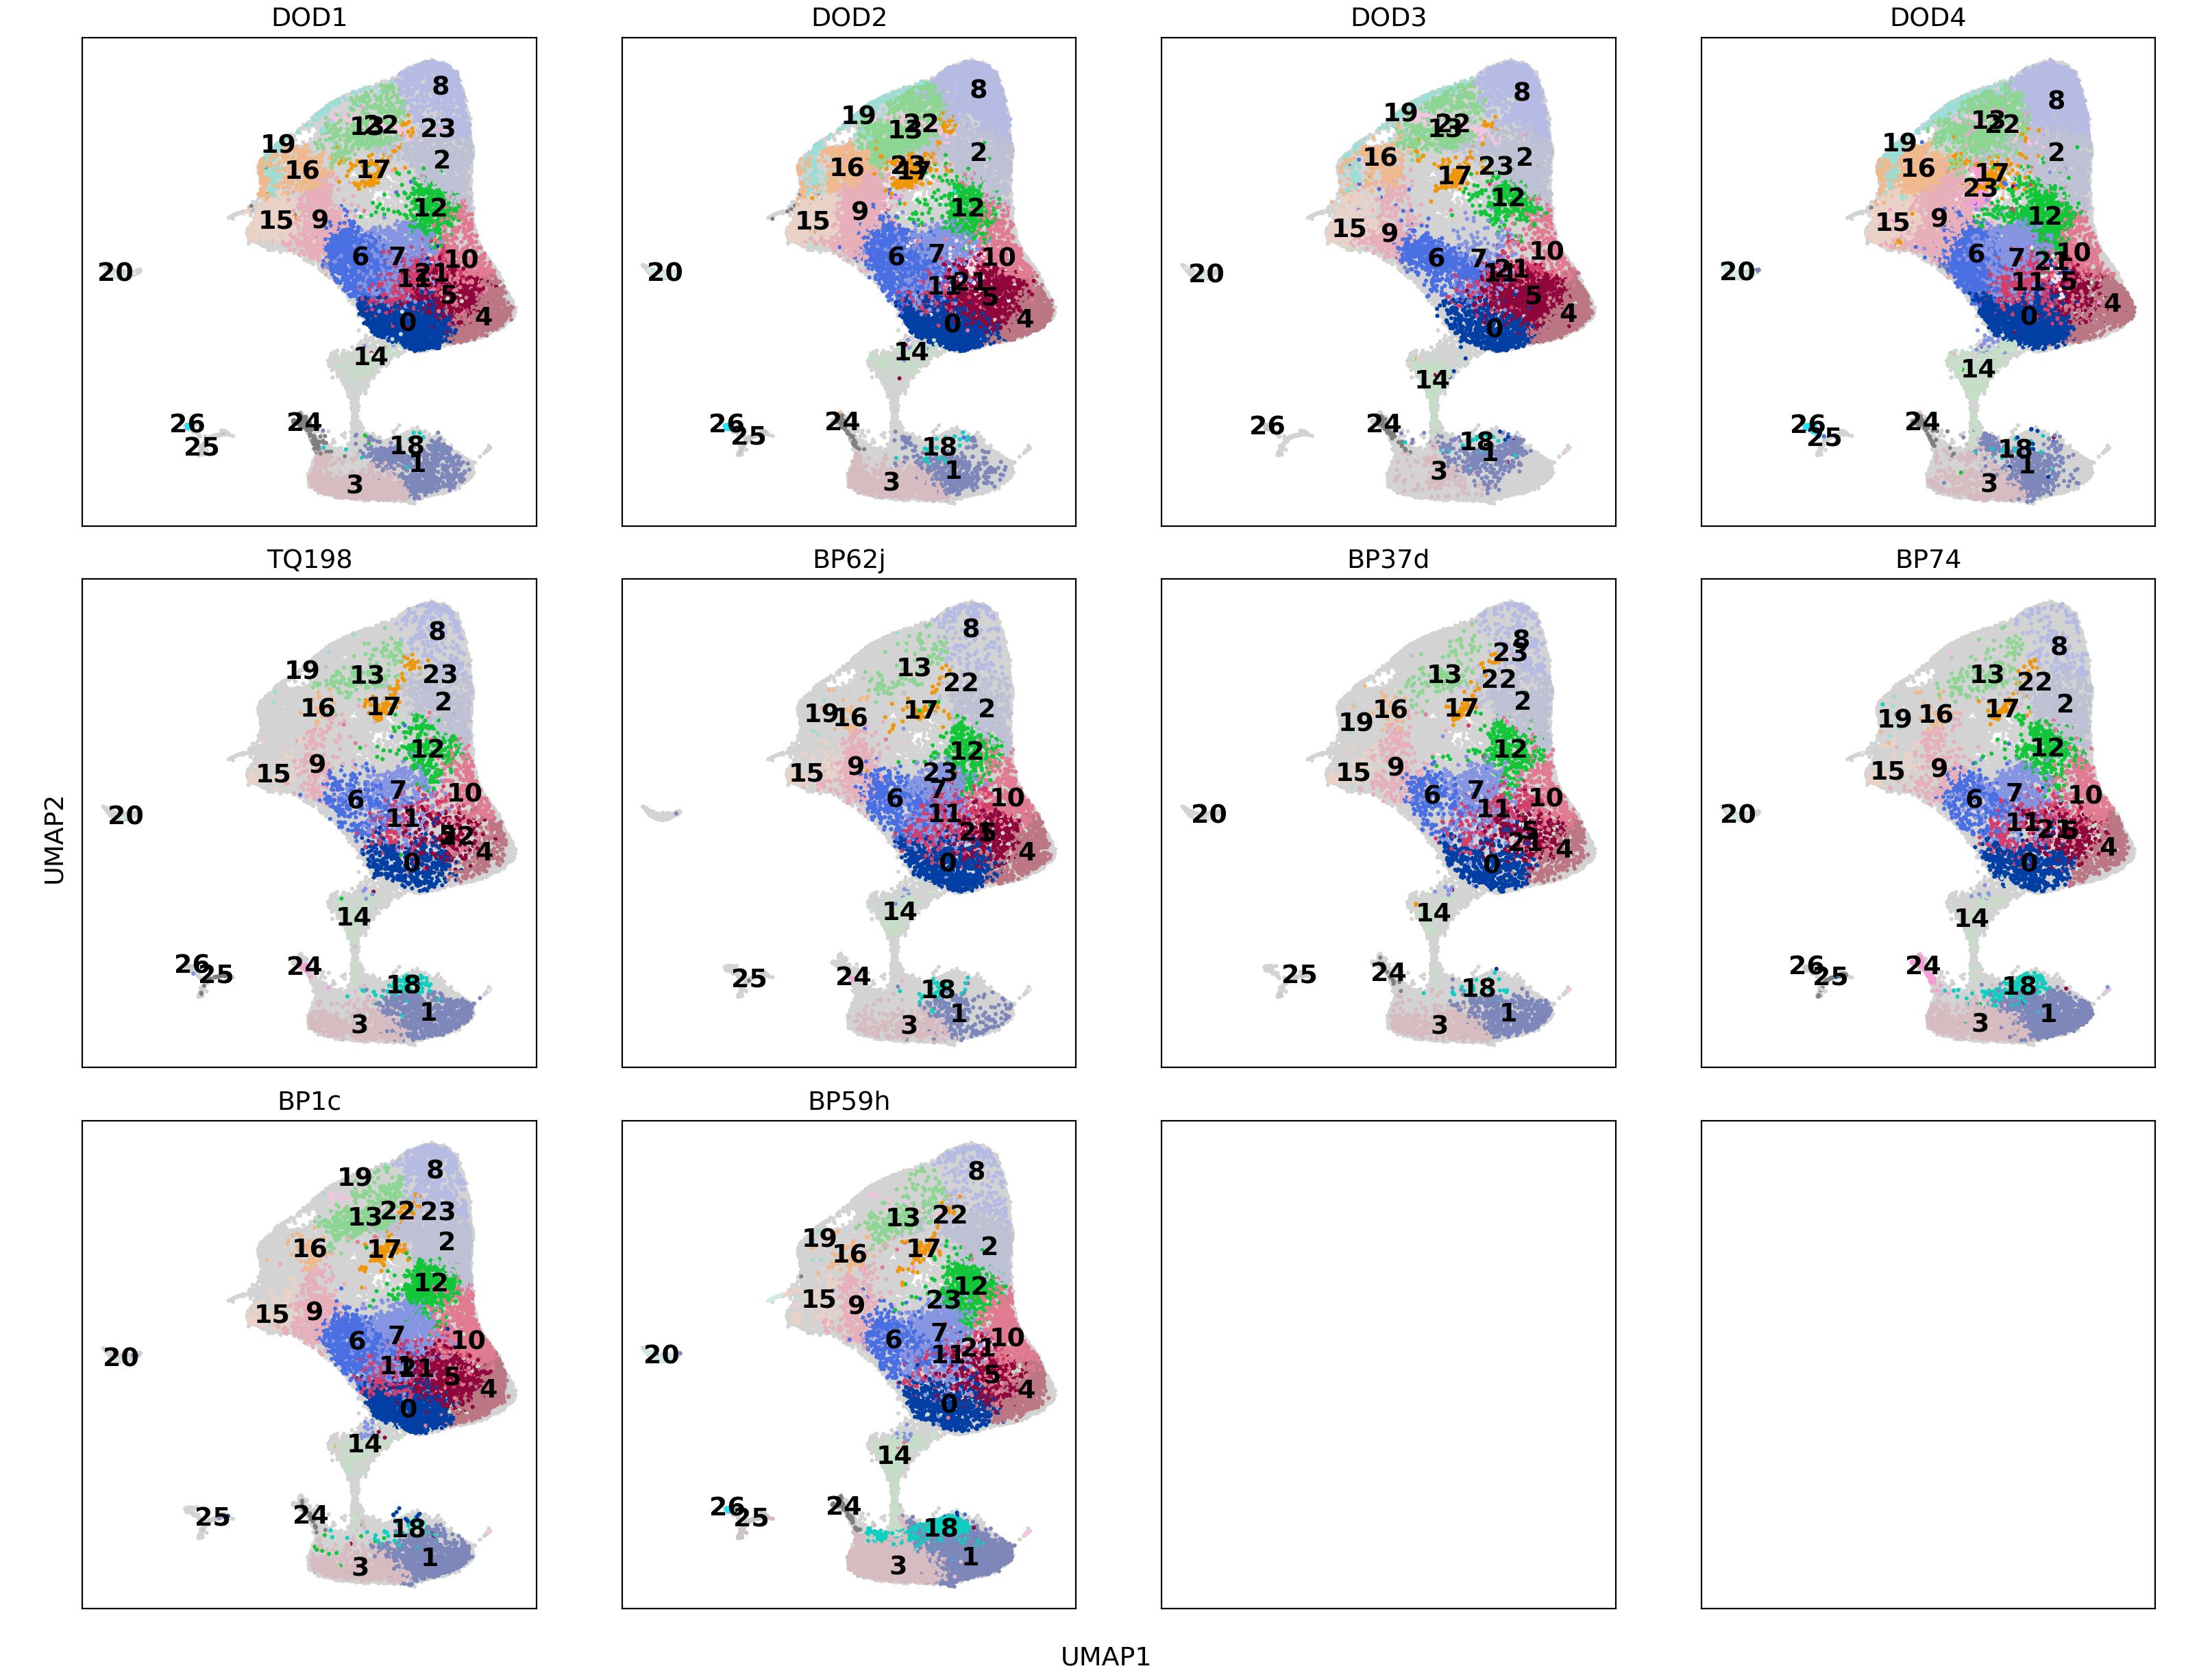

12


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


In [133]:
plot_groupings(data, grouping)

In [134]:
counts = count_cells_per_group(data, grouping)

In [135]:
pd.DataFrame(counts, columns=headers)

cluster   size  D1 BM  D1 PB  D1 SPL  D2 BM  D2 PB  D2 SPL  D3 BM  \
0    cluster 0  11948     71    532    1128    169    992     862    647   
1    cluster 1   8954    349     79     250     40    182     218    347   
2    cluster 2   8828    173    237     296    348    385     343    897   
3    cluster 3   8805     35     30     718     16    135     691    172   
4    cluster 4   8712    579    116     214   1048    415     227   1269   
5    cluster 5   8616    976    311     253    551    813     168   1154   
6    cluster 6   7961    696    361     276    346    753     174    743   
7    cluster 7   7519     57    300     491     77    463     354    213   
8    cluster 8   6772    292    132     341    617    480     326   1072   
9    cluster 9   5598    568     83      79    590    462     193    377   
10  cluster 10   5235    118    104     214    179    208     172    300   
11  cluster 11   4860    185     80     403     38    179      65    182   
12  cluster 12   4384     24    105     225     53    168     195    307   
13  cluster 13   4120    292     37      67    580    190     204    501   
14  cluster 14   3462     48     13      77    130     39      59    617   
15  cluster 15   2800    365     10      19    343    140      59    369   
16  cluster 16   2397    426      2      15    384     94      70    331   
17  cluster 17   1448     83     19      31     84    129      96    215   
18  cluster 18   1170      0      3      10      1     21       3     22   
19  cluster 19   1085    173      2       7    188     30      50    164   
20  cluster 20    919      0      4      41      1      6      78     27   
21  cluster 21    746      0      2       3     59     78     273      1   
22  cluster 22    648     81      0       3    206     10       5     85   
23  cluster 23    610      1      3       0      5      2       4      3   
24  cluster 24    557    103     30      56     17      9      31     69   
25  cluster 25    457      1      2       3      0      3      26      0   
26  cluster 26    172      1      1       8      3     48      12     18   

    D4 BM  D4 SPL  TQ198  BP62j  BP37d  BP74  BP1c  BP59h  
0      30    3580    409    724    469   529  1129    677  
1     212     419    715    225    581   999   971   3367  
2     572     481    533    460    657   617  1624   1205  
3      41     460    479    262    497   805   785   3679  
4    1568     196    225    514    284   385  1033    639  
5    1611      97    199    415    286   271  1083    428  
6    1199     654    274    451    276   347   929    482  
7      86    1445    374    582    498   537  1254    788  
8    1274     699    218    170    207   170   536    238  
9    1247     421    164    265    210   235   414    290  
10    304     172    292    389    310   441  1058    974  
11    518    1462    156    470    242   254   456    170  
12     53     690    263    303    299   366   724    609  
13    739     289    157    100    130   137   473    224  
14    558     572    170    161     74   119   279    546  
15    822     104     54    117     66    77   154    101  
16    779      71     18     29     34    34    53     57  
17    135      66    125     58     97    58   170     82  
18      1      17     96     34     27   189    52    694  
19    402      42      4      4      4     6     2      7  
20     23     206      6      0      4    95     5    423  
21    259      58      0      1      2     1     2      7  
22    120      30      4      6      5    14    35     44  
23    582       3      1      2      1     0     1      2  
24     35      24     10      3     16    62    23     69  
25      1       0     27      1      4    28     6    355  
26     41      19      2      0      0     6     0     13

In [136]:
pd.DataFrame(counts, 
             columns=headers).to_csv('output/'+str(prefix)+basename+'cell_counts_per_donor_leiden_'+res+'.txt', 
                                             sep='\t', index=0)

In [144]:
header = ['donor', 'organ', 
          'leiden.0.6', 'leiden.0.7', 'leiden.0.8',
          'leiden.0.9', 'leiden.1.0', 'leiden.1.1', 
          'leiden.1.2', 'leiden.1.3']

data.obs[header].to_csv('output/'+str(prefix)+basename+'clusters_metadata.txt', 
                                             sep='\t', index=0)